#CreatePickleAllCruises

This script:


*   Loads the data from google sheets
*   Loads WOA
* Interpolates WOA and calculates temperature differences
* Looks for inversions in WOA and historical and flags them
* Saves to pickle


ONLY run this if you are making a change in dataframe. This script takes over 30 minutes to run.

In [ ]:
%%capture
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install geoplot
!pip install gsw
!pip install xarray
!pip install netcdf4
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import pandas as pd
import pyproj as proj
import scipy.interpolate as interpolate
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## LOAD THE DATA

In [ ]:
#url_name='https://docs.google.com/spreadsheets/d/1VJWvSL5mzGKGU3bgp6hEPqDOPDhL4oRiXVur2YMxWQQ/edit#gid=1011727121'
url_name='https://docs.google.com/spreadsheets/d/1VJWvSL5mzGKGU3bgp6hEPqDOPDhL4oRiXVur2YMxWQQ/' #Digitized Records (after clean up)
spreadsheet=gc.open_by_url(url_name)

def getSheetAsXarray(sheetname):
  prof_sheet = spreadsheet.worksheet(sheetname)
  prof_data = prof_sheet.get_all_values()
  df = pd.DataFrame(prof_data)
  df.columns = df.iloc[0]
  df = df.iloc[1:]
  df = df.astype({'Temperature':'float64', 
                  'Lat degrees':'float64', 
                  'Lat minutes':'float64', 
                  'Lon degrees':'float64',
                  'Lon minutes':'float64',
                  'Depth':'float64',
                  'Station':'str'
                  })
  #df = df.set_index(['Station'])
  ds = df.to_xarray()
  ds['lat'] = ds['Lat degrees'] + ds['Lat minutes']/60
  ds['lon'] = ds['Lon degrees'] + ds['Lon minutes']/60
  return ds


ds = getSheetAsXarray('Parsed Profile Data')

#stationkeys = np.delete( stationkeys, 11)
dfv = ds.to_dataframe() 
dfv = dfv.set_index('Station')
dfv = dfv.drop('3') # Stations 3 and 6 are in not in IO
dfv = dfv.drop('6')
dfv = dfv.drop('200-206')
dfv = dfv.drop('135/137')
dfv = dfv.drop('149/152/153')
dfv = dfv.reset_index()
dfv['cruise'] = 'Valdivia'
stationkeys = np.unique(dfv.Station.values)

#dsvi = getSheetAsXarray('Valdivia Interpolated')
#stationkeysvi = np.unique(dsvi.Station.values)

dsp = getSheetAsXarray('Planet Data')

dfp = dsp.to_dataframe() 
dfp['cruise'] = 'Planet'
stationkeysplanet = np.unique(dfp.Station.values)

dsgaz = getSheetAsXarray('Gazelle')

dfg = dsgaz.to_dataframe() 
dfg['cruise'] = 'Gazelle'
stationkeysgazelle = np.unique(dfg.Station.values)


In [ ]:
# loading WOA for each month

def url_month(month_number, old = False):
  #url=f'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/temperature/decav/0.25/woa18_decav_t{month_number}_04.nc' # DECADAL
  url=f'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/temperature/A5B7/0.25/woa18_A5B7_t{month_number}_04.nc' # ARGO 1/4 degree
  if old:
    url=f'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/temperature/5564/1.00/woa18_5564_t{month_number}_01.nc' # 5564 Era 1 degree (no 1/4 degree monthly avail)
  open_dataset = xr.open_dataset(url, decode_times=False)
  return open_dataset

#ARGO era
WOA01 = url_month('01')
WOA02 = url_month('02')
WOA03 = url_month('03')
WOA04 = url_month('04')
WOA05 = url_month('05')
WOA06 = url_month('06')
WOA07 = url_month('07')
WOA08 = url_month('08')
WOA09 = url_month('09')
WOA10 = url_month('10')
WOA11 = url_month('11')
WOA12 = url_month('12')

#1955-
WOA01_o = url_month('01', old=True)
WOA02_o = url_month('02', old=True)
WOA03_o = url_month('03', old=True)
WOA04_o = url_month('04', old=True)
WOA05_o = url_month('05', old=True)
WOA06_o = url_month('06', old=True)
WOA07_o = url_month('07', old=True)
WOA08_o = url_month('08', old=True)
WOA09_o = url_month('09', old=True)
WOA10_o = url_month('10', old=True)
WOA11_o = url_month('11', old=True)
WOA12_o = url_month('12', old=True)

In [ ]:
def url_season(season_number, old=False):
  url=f'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/temperature/decav/0.25/woa18_decav_t{season_number}_04.nc' # DECADAL
  url=f'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/temperature/A5B7/0.25/woa18_A5B7_t{season_number}_04.nc' # ARGO 1/4 degree seasonal (extends deeper)
  if old:
    url=f'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/temperature/5564/0.25/woa18_5564_t{month_number}_04.nc' # 5564 seasonal 1/4 degree (extends deeper)
  open_dataset = xr.open_dataset(url, decode_times=False)
  return open_dataset

WOA_JFM = url_month('13')
WOA_AMJ = url_month('14')
WOA_JAS = url_month('15')
WOA_OND = url_month('16')

WOA_JFM_o = url_month('13', old=True)
WOA_AMJ_o = url_month('14', old=True)
WOA_JAS_o = url_month('15', old=True)
WOA_OND_o = url_month('16', old=True)

In [ ]:
WOA_JFM

In [ ]:
# Setup the Dataframe for the output
ALL_CRUISES = pd.concat([dfg, dfv, dfp])
ALL_CRUISES = ALL_CRUISES.reset_index(drop=True)
ALL_CRUISES.Date = pd.to_datetime(ALL_CRUISES.Date)
ALL_CRUISES['Month'] = pd.DatetimeIndex(ALL_CRUISES['Date']).month

ALL_CRUISES['WOA_temp_monthly'] = np.nan
ALL_CRUISES['WOA_temp_monthly_avg'] = np.nan
ALL_CRUISES['WOA_temp_monthly_rgrd'] = np.nan
ALL_CRUISES['WOA_temp_monthly_avg_rgrd'] = np.nan

ALL_CRUISES['WOA_temp_seasonal'] = np.nan
ALL_CRUISES['WOA_temp_seasonal_avg'] = np.nan
ALL_CRUISES['WOA_temp_seasonal_rgrd'] = np.nan

ALL_CRUISES['delta_T_monthly'] = np.nan
ALL_CRUISES['delta_T_monthly_avg'] = np.nan
ALL_CRUISES['delta_T_monthly_rgrd'] = np.nan
ALL_CRUISES['delta_T_monthly_avg_rgrd'] = np.nan

ALL_CRUISES['delta_T_seasonal'] = np.nan
ALL_CRUISES['delta_T_seasonal_avg'] = np.nan
ALL_CRUISES['delta_T_seasonal_rgrd'] = np.nan
ALL_CRUISES['delta_T_seasonal_avg_rgrd'] = np.nan

ALL_CRUISES['temp_inversion_woa'] = False
ALL_CRUISES['temp_inversion_hist'] = False

#Also calculate 55-64 climatology:
ALL_CRUISES['delta_T_monthly_5564'] = np.nan
ALL_CRUISES['WOA_temp_monthly_5564'] = np.nan
ALL_CRUISES['delta_T_seasonal_5564'] = np.nan
ALL_CRUISES['WOA_temp_seasonal_5564'] = np.nan

ALL_CRUISES

## Do interpolation of WOA Data

There are several options for how we interpolate, based on data exploration:


1.   **Interpolation:** This does a naive interpolation using depth, lat, lon as 3 coordinates. Note this is inexact as the distance per degree longitude varies widely over the domain. Still it is not too bad as the high res WOA data means you are only interpolating over a few points. Still, this is not the best choice to use.
2.   **Regridding:** Instead of using lat/lon directly, transform them to a Cartesian coordinate system, with a *local* center at the historical station point. Here we interpolate on depth first, then regrid, then horizontally. This is the most accurate method.

Finally, there are some options in the WOA dataset that give rise to permutations. Specifically: **t_an** is the objectively averaged temperature, **t_mn** is the naive averaged temperature, and then there is monthly data (better temporal resolution) and seasonal data (extends deeper into the water column). Generally it is recommended to stick with **t_an** and use seasonal data to fill in missing monthly as needed (particularly at depth where seasonal variability should be small).

So, the output convention is:
ALL_CRUISES['delta_T_monthly'] = np.nan
ALL_CRUISES['delta_T_monthly_avg'] = np.nan
ALL_CRUISES['delta_T_monthly_rgrd'] = np.nan
ALL_CRUISES['delta_T_monthly_avg_rgrd'] = np.nan

*   delta_T_timeperiod -- Naive interpolation + objectively analyzed
*   delta_T_timeperiod_avg -- Naive interpolation + averaged temps
* delta_T_timeperiod_rgrd -- Spatial regridding + objectively analyzed (use this)
* delta_T_timeperiod_avg_rgrd -- Spatial regridding + averaged temps





In [1]:
#Erect own local flat cartesian coordinate system around mean lat/lon for each station
#Necessary to define a projection method, which is done here
crs_wgs = proj.Proj(init='epsg:4326')  # assuming you're using WGS84 geographic


NameError: ignored

In [ ]:
# This function calculates differences in temperature using seasonal data
# Inputs: 
#         - ind = index of row to calculate
#         - df. = dataframe to calculate on
#         - regrid = Flag on whether to regrid spatial coordinates
#         - avg.   = Flag on whether to use the naive averaged WOA temps
#         - old.   = Flag on whether to use the 5564 climatology
def WOA_diff_season(ind, df, regrid=False, avg=False, old=False):
  month_dict = {1:WOA_JFM, 
                2:WOA_JFM, 
                3:WOA_JFM, 
                4:WOA_AMJ, 
                5:WOA_AMJ, 
                6:WOA_AMJ, 
                7:WOA_JAS, 
                8:WOA_JAS, 
                9:WOA_JAS, 
                10:WOA_OND, 
                11:WOA_OND, 
                12:WOA_OND}
  if old:
        month_dict = {1:WOA_JFM_o, 
                2:WOA_JFM_o, 
                3:WOA_JFM_o, 
                4:WOA_AMJ_o, 
                5:WOA_AMJ_o, 
                6:WOA_AMJ_o, 
                7:WOA_JAS_o, 
                8:WOA_JAS_o, 
                9:WOA_JAS_o, 
                10:WOA_OND_o, 
                11:WOA_OND_o, 
                12:WOA_OND_o}      
  woa_temp = month_dict[df.at[ind,'Month']]
  # Subset the WOA data and meshgrid for interpolation
  WLON, WLAT = np.meshgrid(woa_temp.sel(lat=slice(-60, 30), lon=slice(0, 150)).lon, woa_temp.sel(lat=slice(-60, 30), lon=slice(0, 150)).lat)
 
  # Pick the WOA temperature variable based on input flags
  if avg: # Naive averaged temperature
    insitu_temp = woa_temp.sel(lat=slice(-60, 30), lon=slice(0, 150))['t_mn']
  else: # Objectively analyzed temperature
    insitu_temp=woa_temp.sel(lat=slice(-60, 30), lon=slice(0, 150))['t_an']

  # Select the data frame row that is being calculated
  dset = df.to_xarray()
  temps = dset.isel(index = ind).Temperature
  depths = dset.isel(index = ind).Depth
  lons = dset.isel(index = ind).lon
  lats = dset.isel(index = ind).lat

  # Do the interpolation of WOA -> historical locations
  if regrid: # If regridding horizontally:
    # Center the projection around the historical location
    cust = proj.Proj("+proj=aeqd +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(lats.values,lons.values))
    x, y = proj.transform(crs_wgs, cust, lons, lats)
    # Interpolate woa vertically and flatten it (ravel)
    woaflat = np.ravel(insitu_temp.isel(time=0).interp(depth = depths, method='linear').values)
    mask = np.isfinite(woaflat)
    # transform the WOA lats and lons to cartesian distance
    fx, fy = proj.transform(crs_wgs, cust, WLON, WLAT)
    fxf = np.ravel(fx)
    fyf = np.ravel(fy)
    # do the horizontal interpolation
    newtemps = float(interpolate.griddata((fxf[mask], fyf[mask]), woaflat[mask], [x,y]))
  else:
    # Do vertical and horizontal interpolation at the same time
    newtemps = float(insitu_temp.isel(time=0).interp(lon=lons, lat=lats, depth=depths, method='linear').values)

  # calculate the difference between modern and historical
  tdiff = newtemps - float(temps.values)

  return newtemps, tdiff

In [ ]:
#Do a quick test of the methods
indtest = 2
newtemps, tdiff = WOA_diff_season(ind=indtest, df=ALL_CRUISES)
print(f'OBJ, Spatial Avg: {newtemps}')
newtemps, tdiff = WOA_diff_season(ind=indtest, df=ALL_CRUISES, regrid=True)
print(f'OBJ, Spatial Rgrd: {newtemps}')


OBJ, Spatial Avg: 11.302156548394091
OBJ, Spatial Rgrd: 11.250414529000574


In [ ]:
# This function calculates differences in temperature using monthly data
# Inputs: 
#         - ind = index of row to calculate
#         - df. = dataframe to calculate on
#         - regrid = Flag on whether to regrid spatial coordinates
#         - avg.   = Flag on whether to use the naive averaged WOA temps
#         - old.   = Flag on whether to use the 5564 climatology

def WOA_diff(ind, df, regrid=False, avg=False, old=False):
  month_dict = {1:WOA01, 2:WOA02, 3:WOA03, 4:WOA04, 5:WOA05, 6:WOA06, 7:WOA07, 8:WOA08, 9:WOA09, 10:WOA10, 11:WOA11, 12:WOA12}
  if old:
    month_dict = {1:WOA01_o, 2:WOA02_o, 3:WOA03_o, 4:WOA04_o, 5:WOA05_o, 6:WOA06_o, 7:WOA07_o, 8:WOA08_o, 9:WOA09_o, 10:WOA10_o, 11:WOA11_o, 12:WOA12_o}

  woa_temp = month_dict[df.at[ind,'Month']]
  # Subset the WOA data and meshgrid for interpolation
  WLON, WLAT = np.meshgrid(woa_temp.sel(lat=slice(-60, 30), lon=slice(0, 150)).lon, woa_temp.sel(lat=slice(-60, 30), lon=slice(0, 150)).lat)
 
  # Pick the WOA temperature variable based on input flags
  if avg: # Naive averaged temperature
    insitu_temp = woa_temp.sel(lat=slice(-60, 30), lon=slice(0, 150))['t_mn']
  else: # Objectively analyzed temperature
    insitu_temp=woa_temp.sel(lat=slice(-60, 30), lon=slice(0, 150))['t_an']

  # Select the data frame row that is being calculated
  dset = df.to_xarray()
  temps = dset.isel(index = ind).Temperature
  depths = dset.isel(index = ind).Depth
  lons = dset.isel(index = ind).lon
  lats = dset.isel(index = ind).lat

  # Do the interpolation of WOA -> historical locations
  if regrid: # If regridding horizontally:
    # Center the projection around the historical location
    cust = proj.Proj("+proj=aeqd +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(lats.values,lons.values))
    x, y = proj.transform(crs_wgs, cust, lons, lats)
    # Interpolate woa vertically and flatten it (ravel)
    woaflat = np.ravel(insitu_temp.isel(time=0).interp(depth = depths, method='linear').values)
    mask = np.isfinite(woaflat)
    # transform the WOA lats and lons to cartesian distance
    fx, fy = proj.transform(crs_wgs, cust, WLON, WLAT)
    fxf = np.ravel(fx)
    fyf = np.ravel(fy)
    # do the horizontal interpolation
    newtemps = float(interpolate.griddata((fxf[mask], fyf[mask]), woaflat[mask], [x,y]))
  else:
    # Do vertical and horizontal interpolation at the same time
    newtemps = float(insitu_temp.isel(time=0).interp(lon=lons, lat=lats, depth=depths, method='linear').values)

  # calculate the difference between modern and historical
  tdiff = newtemps - float(temps.values)

  return newtemps, tdiff

# def WOA_diff(ind, df, regrid=False, avg=False, old=False):
#   month_dict = {1:WOA01, 2:WOA02, 3:WOA03, 4:WOA04, 5:WOA05, 6:WOA06, 7:WOA07, 8:WOA08, 9:WOA09, 10:WOA10, 11:WOA11, 12:WOA12}
#   if old:
#     month_dict = {1:WOA01_o, 2:WOA02_o, 3:WOA03_o, 4:WOA04_o, 5:WOA05_o, 6:WOA06_o, 7:WOA07_o, 8:WOA08_o, 9:WOA09_o, 10:WOA10_o, 11:WOA11_o, 12:WOA12_o}
#   woa_temp = month_dict[df.at[ind,'Month']]
#   WLON, WLAT = np.meshgrid(woa_temp.sel(lat=slice(-60, 30), lon=slice(0, 150)).lon, woa_temp.sel(lat=slice(-60, 30), lon=slice(0, 150)).lat)

#   #insitu_temp=woa_temp.sel(lat=slice(-60, 30), lon=slice(0, 150))['t_an']
#   if avg:
#     insitu_temp = woa_temp.sel(lat=slice(-60, 30), lon=slice(0, 150))['t_mn']
#   else:
#     insitu_temp=woa_temp.sel(lat=slice(-60, 30), lon=slice(0, 150))['t_an']

#   dset = df.to_xarray()

#   temps = dset.isel(index = ind).Temperature
#   depths = dset.isel(index = ind).Depth
#   lons = dset.isel(index = ind).lon
#   lats = dset.isel(index = ind).lat

#   #newtemps = float(insitu_temp.isel(time=0).interp(lon=lons, lat=lats, depth=depths, method='linear').values)
#   if regrid:
#     cust = proj.Proj("+proj=aeqd +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(lats.values,lons.values))
#     x, y = proj.transform(crs_wgs, cust, lons, lats)
#     woaflat = np.ravel(insitu_temp.isel(time=0).interp(depth = depths, method='linear').values)
#     mask = np.isfinite(woaflat)
#     fx, fy = proj.transform(crs_wgs, cust, WLON, WLAT)
#     fxf = np.ravel(fx)
#     fyf = np.ravel(fy)
#     newtemps = float(interpolate.griddata((fxf[mask], fyf[mask]), woaflat[mask], [x,y]))
#   else:
#       newtemps = float(insitu_temp.isel(time=0).interp(lon=lons, lat=lats, depth=depths, method='linear').values)


#   tdiff = newtemps - float(temps.values)

#   #row = int(dset.isel(index=ind).index.values)

#   return newtemps, tdiff


In [ ]:
# Quick test the monthly differences
indtest = 368

newtemps, tdiff = WOA_diff(ind=indtest, df=ALL_CRUISES)
print(f'OBJ, Spatial Avg: {newtemps}')
newtemps, tdiff = WOA_diff(ind=indtest, df=ALL_CRUISES, regrid=True)
print(f'OBJ, Spatial Rgrd: {newtemps}')
newtemps, tdiff = WOA_diff_season(ind=indtest, df=ALL_CRUISES, regrid=True)
print(f'OBJ, Spatial Rgrd, Season: {newtemps}')

OBJ, Spatial Avg: 8.870070828331842
OBJ, Spatial Rgrd: 8.870183702322246
OBJ, Spatial Rgrd, Season: 8.621182008908256


In [ ]:
ALL_CRUISES

,Station,Date,Lat degrees,Lat minutes,Lon degrees,Lon minutes,Bottom,Depth,Temperature,Notes,lat,lon,cruise,,Month,WOA_temp_monthly,WOA_temp_monthly_avg,WOA_temp_monthly_rgrd,WOA_temp_monthly_avg_rgrd,WOA_temp_seasonal,WOA_temp_seasonal_avg,WOA_temp_seasonal_rgrd,delta_T_monthly,delta_T_monthly_avg,delta_T_monthly_rgrd,delta_T_monthly_avg_rgrd,delta_T_seasonal,delta_T_seasonal_avg,delta_T_seasonal_rgrd,delta_T_seasonal_avg_rgrd,temp_inversion_woa,temp_inversion_hist,delta_T_monthly_5564,WOA_temp_monthly_5564,delta_T_seasonal_5564,WOA_temp_seasonal_5564
0,38,1874-10-04,-34.0,-6.5,18.0,6.5,214,0.0,14.8,,-34.108333,18.108333,Gazelle,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN
1,38,1874-10-04,-34.0,-6.5,18.0,6.5,214,55.0,11.6,,-34.108333,18.108333,Gazelle,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN
2,38,1874-10-04,-34.0,-6.5,18.0,6.5,214,91.0,9.7,,-34.108333,18.108333,Gazelle,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN
3,38,1874-10-04,-34.0,-6.5,18.0,6.5,214,146.0,8.1,,-34.108333,18.108333,Gazelle,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN
4,38,1874-10-04,-34.0,-6.5,18.0,6.5,214,214.0,6.9,,-34.108333,18.108333,Gazelle,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,181,1906-08-14,-9.0,-18.0,112.0,9.0,1001,100.0,20.0,,-9.300000,112.150000,Planet,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN
615,181,1906-08-14,-9.0,-18.0,112.0,9.0,1001,125.0,16.9,,-9.300000,112.150000,Planet,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN
616,181,1906-08-14,-9.0,-18.0,112.0,9.0,1001,150.0,15.7,,-9.300000,112.150000,Planet,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN
617,181,1906-08-14,-9.0,-18.0,112.0,9.0,1001,400.0,9.6,,-9.300000,112.150000,Planet,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN


## RUN THE FULL ANALYSIS

The following code iterates through the whole dataframe to run the analysis.

It can be slow (>30 min) so should only be run when trying to remake the pickle.

In [ ]:
#running seasonal for whole dataframe!!

for i in range(0,ALL_CRUISES.index.size):
  newtemps, tdiff = WOA_diff_season(ind=i, df=ALL_CRUISES)
  ALL_CRUISES.at[i,'WOA_temp_seasonal'] = newtemps
  ALL_CRUISES.at[i, 'delta_T_seasonal'] = tdiff
  try:
    newtemps, tdiff = WOA_diff_season(ind=i, df=ALL_CRUISES, regrid=True)
    ALL_CRUISES.at[i,'WOA_temp_seasonal_rgrd'] = newtemps
    ALL_CRUISES.at[i, 'delta_T_seasonal_rgrd'] = tdiff
  except:
    print(f'No data at index {i}')
  #try:
  #  newtemps, tdiff = WOA_diff_season(ind=i, df=ALL_CRUISES, regrid=True, avg=True)
  #  ALL_CRUISES.at[i,'WOA_temp_seasonal_avg_rgrd'] = newtemps
  #  ALL_CRUISES.at[i, 'delta_T_seasonal_avg_rgrd'] = tdiff
  #except:
  #  print(f'No data at index {i}')
  try:
    newtemps, tdiff = WOA_diff_season(ind=i, df=ALL_CRUISES, regrid=True, old=True)
    ALL_CRUISES.at[i, 'WOA_temp_seasonal_5564'] = newtemps
    ALL_CRUISES.at[i, 'delta_T_seasonal_5564'] = tdiff
  except:
    print(f'No data at index {i}')
  print(f'done {i}')
  clear_output(wait=True)
  print(f'Done: {i}/{ALL_CRUISES.index.size}')

Done: 618/619


In [ ]:

#running monthly for whole dataframe!!

for i in range(0,ALL_CRUISES.index.size):
  newtemps, tdiff = WOA_diff(ind=i, df=ALL_CRUISES)
  ALL_CRUISES.at[i,'WOA_temp_monthly'] = newtemps
  ALL_CRUISES.at[i, 'delta_T_monthly'] = tdiff
  try:
    newtemps, tdiff = WOA_diff(ind=i, df=ALL_CRUISES, regrid=True)
    ALL_CRUISES.at[i,'WOA_temp_monthly_rgrd'] = newtemps
    ALL_CRUISES.at[i, 'delta_T_monthly_rgrd'] = tdiff
  except:
    print(f'No data at index {i}')
  #try:
  #  newtemps, tdiff = WOA_diff(ind=i, df=ALL_CRUISES, regrid=True, avg=True)
  #  ALL_CRUISES.at[i,'WOA_temp_monthly_avg_rgrd'] = newtemps
  #  ALL_CRUISES.at[i, 'delta_T_monthly_avg_rgrd'] = tdiff
  #except:
  #  print(f'No data at index {i}')
  try:
    newtemps, tdiff = WOA_diff(ind=i, df=ALL_CRUISES, regrid=True, old=True)
    ALL_CRUISES.at[i, 'WOA_temp_monthly_5564'] = newtemps
    ALL_CRUISES.at[i, 'delta_T_monthly_5564'] = tdiff
  except:
    print(f'No data at index {i}')
  #print(f'done {i}')
  clear_output(wait=True)
  print(f'Done: {i}/{ALL_CRUISES.index.size}')


Done: 618/619


In [ ]:
ALL_CRUISES

,Station,Date,Lat degrees,Lat minutes,Lon degrees,Lon minutes,Bottom,Depth,Temperature,Notes,lat,lon,cruise,,Month,WOA_temp_monthly,WOA_temp_monthly_avg,WOA_temp_monthly_rgrd,WOA_temp_monthly_avg_rgrd,WOA_temp_seasonal,WOA_temp_seasonal_avg,WOA_temp_seasonal_rgrd,delta_T_monthly,delta_T_monthly_avg,delta_T_monthly_rgrd,delta_T_monthly_avg_rgrd,delta_T_seasonal,delta_T_seasonal_avg,delta_T_seasonal_rgrd,delta_T_seasonal_avg_rgrd,temp_inversion_woa,temp_inversion_hist,delta_T_monthly_5564,WOA_temp_monthly_5564,delta_T_seasonal_5564,WOA_temp_seasonal_5564
0,38,1874-10-04,-34.0,-6.5,18.0,6.5,214,0.0,14.8,,-34.108333,18.108333,Gazelle,NaN,10,16.244640,NaN,16.239186,NaN,16.759469,NaN,16.755567,1.444640,NaN,1.439186,NaN,1.959469,NaN,1.955567,NaN,False,False,1.224981,16.024981,2.358797,17.158797
1,38,1874-10-04,-34.0,-6.5,18.0,6.5,214,55.0,11.6,,-34.108333,18.108333,Gazelle,NaN,10,14.049005,NaN,14.027722,NaN,13.538749,NaN,13.510644,2.449005,NaN,2.427722,NaN,1.938749,NaN,1.910644,NaN,False,False,3.113264,14.713264,3.216337,14.816337
2,38,1874-10-04,-34.0,-6.5,18.0,6.5,214,91.0,9.7,,-34.108333,18.108333,Gazelle,NaN,10,11.929184,NaN,11.886170,NaN,11.302157,NaN,11.250415,2.229184,NaN,2.186170,NaN,1.602157,NaN,1.550415,NaN,False,False,3.485590,13.185590,3.074797,12.774797
3,38,1874-10-04,-34.0,-6.5,18.0,6.5,214,146.0,8.1,,-34.108333,18.108333,Gazelle,NaN,10,10.374460,NaN,10.317534,NaN,9.751197,NaN,9.687888,2.274460,NaN,2.217534,NaN,1.651197,NaN,1.587888,NaN,False,False,3.160125,11.260125,2.884723,10.984723
4,38,1874-10-04,-34.0,-6.5,18.0,6.5,214,214.0,6.9,,-34.108333,18.108333,Gazelle,NaN,10,NaN,NaN,9.557381,NaN,NaN,NaN,8.987359,NaN,NaN,2.657381,NaN,NaN,NaN,2.087359,NaN,False,False,2.974293,9.874293,3.015446,9.915446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,181,1906-08-14,-9.0,-18.0,112.0,9.0,1001,100.0,20.0,,-9.300000,112.150000,Planet,NaN,8,16.102701,NaN,16.101931,NaN,17.735036,NaN,17.733986,-3.897299,NaN,-3.898069,NaN,-2.264964,NaN,-2.266014,NaN,False,False,-2.065445,17.934555,-1.867590,18.132410
615,181,1906-08-14,-9.0,-18.0,112.0,9.0,1001,125.0,16.9,,-9.300000,112.150000,Planet,NaN,8,14.094938,NaN,14.093989,NaN,15.824085,NaN,15.823520,-2.805062,NaN,-2.806011,NaN,-1.075915,NaN,-1.076480,NaN,False,False,-1.920360,14.979640,-1.197060,15.702940
616,181,1906-08-14,-9.0,-18.0,112.0,9.0,1001,150.0,15.7,,-9.300000,112.150000,Planet,NaN,8,13.125438,NaN,13.124210,NaN,14.174307,NaN,14.173973,-2.574562,NaN,-2.575790,NaN,-1.525693,NaN,-1.526027,NaN,False,False,-2.105618,13.594382,-1.745925,13.954075
617,181,1906-08-14,-9.0,-18.0,112.0,9.0,1001,400.0,9.6,,-9.300000,112.150000,Planet,NaN,8,8.994917,NaN,8.994727,NaN,9.288225,NaN,9.287846,-0.605083,NaN,-0.605273,NaN,-0.311775,NaN,-0.312154,NaN,False,False,-0.894249,8.705751,-0.727338,8.872662


## Check Inversions

We are concerned with temperature inversions because of the min/max thermometers. So we flag them both in the WOA and historical data.

In [ ]:
# This function checks if there are inversions at the WOA seasonal data
# It requires an upper and lower limit to consider, upper because in the ML there are sometimes inversions
# lower because the deep ocean sometimes has inversions (below what we are considering in this analysis)
# Nb. Could do this also with monthly data, however seasonal should be fine as we are concerned with persistent inversions.
def checkInversion_woa(ind, df, uplim = 200, lowlim=2000):
    month_dict = {1:WOA_JFM, 
                2:WOA_JFM, 
                3:WOA_JFM, 
                4:WOA_AMJ, 
                5:WOA_AMJ, 
                6:WOA_AMJ, 
                7:WOA_JAS, 
                8:WOA_JAS, 
                9:WOA_JAS, 
                10:WOA_OND, 
                11:WOA_OND, 
                12:WOA_OND}
    #month_dict = {1:WOA01, 2:WOA02, 3:WOA03, 4:WOA04, 5:WOA05, 6:WOA06, 7:WOA07, 8:WOA08, 9:WOA09, 10:WOA10, 11:WOA11, 12:WOA12}

    woa_temp = month_dict[df.at[ind,'Month']]
    insitu_temp=woa_temp.sel(lat=slice(-60, 30), lon=slice(0, 150))['t_an']
    dset = df.to_xarray()

    lons = dset.isel(index = ind).lon
    lats = dset.isel(index = ind).lat
    # Just doing a naive lat/lon interpolation here for speed
    woa_temp_int = insitu_temp.isel(time=0).interp(lon=lons, lat=lats, method='nearest')
    woa_temp_dz = woa_temp_int.diff('depth')

    #Flag any station where there is an inversion in the water column    
    inv = woa_temp_dz.where(np.logical_and(woa_temp_dz.depth>uplim, woa_temp_dz.depth<lowlim))>0
    return any(inv), woa_temp_int, woa_temp_dz
  
flag, woa_temp, woa_dz = checkInversion_woa(72, ALL_CRUISES, uplim=500)
print(flag)

True


In [ ]:
# This code flags if there are inversions in the WOA at each profile location
# This is an inefficient approach (doing each row), but it only needs to be run once.
for i in range(0,ALL_CRUISES.index.size):
  flag, woa_temp, woa_dz = checkInversion_woa(i, ALL_CRUISES, uplim=500, lowlim=4000)
  ALL_CRUISES.at[i,'temp_inversion_woa'] = flag
  clear_output(wait=True)
  print(f'Done: {i}/{ALL_CRUISES.index.size}')

Done: 618/619


In [ ]:
# We also need to look for inversions in the historical profiles
# What to do with these is more complicated, but good to know when they are there
def checkInversion_hist(ind, df, uplim = 200, lowlim=2000):
  
    dset = df.to_xarray()

    cruise = dset.sel(index=ind).cruise
    station = dset.sel(index=ind).Station
    dset = dset.where(np.logical_and(dset.cruise==cruise, dset.Station==station), drop=True)
    temps = dset.Temperature
    temps_dz = dset.Temperature.diff('index')
    dz = dset.Depth.diff('index')
    temps_dz = temps_dz/dz
    inv = temps_dz>0

    # Flagging whole stations
    return any(inv), temps, temps_dz, dset.Depth, dz
  
ind = 71
flag, temp, t_dz, depth, depth_dz = checkInversion_hist(ind, ALL_CRUISES, uplim=500)
print(flag)


True


In [ ]:
# This code checks if there are inversions in the whole historical dataset
for i in range(0,ALL_CRUISES.index.size):
  flag = checkInversion_hist(i, ALL_CRUISES)[0]
  ALL_CRUISES.at[i,'temp_inversion_hist'] = flag
  clear_output(wait=True)
  print(f'Done: {i}/{ALL_CRUISES.index.size}')

Done: 618/619


## SAVE DATAFRAME TO PICKLE

Note change log in comments!

In [ ]:
#v0p5 - rerunning to add the 5564 WOD18 data, removing the 'avg' fields
#v0p6 - Using the parsed profile data from Valdivia, accounting for mixed stations in profile
#v0p7 - Updating 5564 seasonal to use the 1/4 degree climatology
#v0p8 - Updating Emma's sheet after double-entry comparison
ALL_CRUISES.to_pickle('/content/drive/My Drive/WOD Historic Data/ALL_CRUISES_v0p8.pkl')

In [ ]:
cruise_df = pd.read_pickle('/content/drive/My Drive/WOD Historic Data/ALL_CRUISES_v0p8.pkl')

In [ ]:
cruise_df

,Station,Date,Lat degrees,Lat minutes,Lon degrees,Lon minutes,Bottom,Depth,Temperature,Notes,lat,lon,cruise,,Month,WOA_temp_monthly,WOA_temp_monthly_avg,WOA_temp_monthly_rgrd,WOA_temp_monthly_avg_rgrd,WOA_temp_seasonal,WOA_temp_seasonal_avg,WOA_temp_seasonal_rgrd,delta_T_monthly,delta_T_monthly_avg,delta_T_monthly_rgrd,delta_T_monthly_avg_rgrd,delta_T_seasonal,delta_T_seasonal_avg,delta_T_seasonal_rgrd,delta_T_seasonal_avg_rgrd,temp_inversion_woa,temp_inversion_hist,delta_T_monthly_5564,WOA_temp_monthly_5564,delta_T_seasonal_5564,WOA_temp_seasonal_5564
0,38,1874-10-04,-34.0,-6.5,18.0,6.5,214,0.0,14.8,,-34.108333,18.108333,Gazelle,NaN,10,16.244640,NaN,16.239186,NaN,16.759469,NaN,16.755567,1.444640,NaN,1.439186,NaN,1.959469,NaN,1.955567,NaN,False,False,1.224981,16.024981,2.358797,17.158797
1,38,1874-10-04,-34.0,-6.5,18.0,6.5,214,55.0,11.6,,-34.108333,18.108333,Gazelle,NaN,10,14.049005,NaN,14.027722,NaN,13.538749,NaN,13.510644,2.449005,NaN,2.427722,NaN,1.938749,NaN,1.910644,NaN,False,False,3.113264,14.713264,3.216337,14.816337
2,38,1874-10-04,-34.0,-6.5,18.0,6.5,214,91.0,9.7,,-34.108333,18.108333,Gazelle,NaN,10,11.929184,NaN,11.886170,NaN,11.302157,NaN,11.250415,2.229184,NaN,2.186170,NaN,1.602157,NaN,1.550415,NaN,False,False,3.485590,13.185590,3.074797,12.774797
3,38,1874-10-04,-34.0,-6.5,18.0,6.5,214,146.0,8.1,,-34.108333,18.108333,Gazelle,NaN,10,10.374460,NaN,10.317534,NaN,9.751197,NaN,9.687888,2.274460,NaN,2.217534,NaN,1.651197,NaN,1.587888,NaN,False,False,3.160125,11.260125,2.884723,10.984723
4,38,1874-10-04,-34.0,-6.5,18.0,6.5,214,214.0,6.9,,-34.108333,18.108333,Gazelle,NaN,10,NaN,NaN,9.557381,NaN,NaN,NaN,8.987359,NaN,NaN,2.657381,NaN,NaN,NaN,2.087359,NaN,False,False,2.974293,9.874293,3.015446,9.915446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,181,1906-08-14,-9.0,-18.0,112.0,9.0,1001,100.0,20.0,,-9.300000,112.150000,Planet,NaN,8,16.102701,NaN,16.101931,NaN,17.735036,NaN,17.733986,-3.897299,NaN,-3.898069,NaN,-2.264964,NaN,-2.266014,NaN,True,False,-2.065445,17.934555,-1.867590,18.132410
615,181,1906-08-14,-9.0,-18.0,112.0,9.0,1001,125.0,16.9,,-9.300000,112.150000,Planet,NaN,8,14.094938,NaN,14.093989,NaN,15.824085,NaN,15.823520,-2.805062,NaN,-2.806011,NaN,-1.075915,NaN,-1.076480,NaN,True,False,-1.920360,14.979640,-1.197060,15.702940
616,181,1906-08-14,-9.0,-18.0,112.0,9.0,1001,150.0,15.7,,-9.300000,112.150000,Planet,NaN,8,13.125438,NaN,13.124210,NaN,14.174307,NaN,14.173973,-2.574562,NaN,-2.575790,NaN,-1.525693,NaN,-1.526027,NaN,True,False,-2.105618,13.594382,-1.745925,13.954075
617,181,1906-08-14,-9.0,-18.0,112.0,9.0,1001,400.0,9.6,,-9.300000,112.150000,Planet,NaN,8,8.994917,NaN,8.994727,NaN,9.288225,NaN,9.287846,-0.605083,NaN,-0.605273,NaN,-0.311775,NaN,-0.312154,NaN,True,False,-0.894249,8.705751,-0.727338,8.872662


Code below is here for convenience, but see also 'DataQualityCheck.ipynb'.

## CHECKING INVERSIONS

23


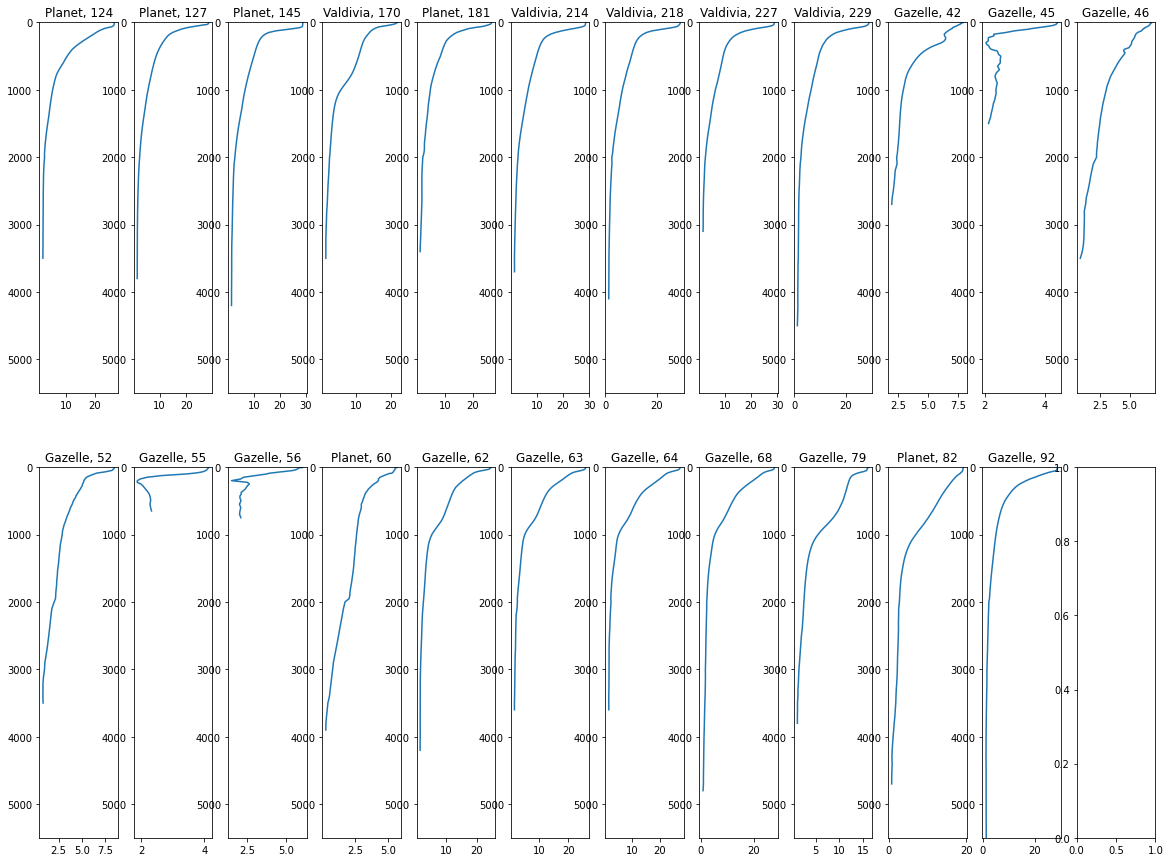

In [ ]:
ac = ALL_CRUISES.to_xarray()
ac = ac.where(ac.temp_inversion_woa, drop=True)

numinv = np.unique(ac.Station.values).size
print(numinv)
fig, ax = plt.subplots(2,12, figsize=(20,15))
counter = 0
for s in np.unique(ac.Station.values):
  #print(s)
  index = ac.where(ac.Station==s, drop=True).index.values[0]
  flag, woa_temp, woa_dz = checkInversion_woa(index, ALL_CRUISES, uplim=500)
  ax.ravel()[counter].plot(woa_temp, woa_temp.depth)
  ax.ravel()[counter].set_title(f'{ac.sel(index=index).cruise.values}, {s}')
  ax.ravel()[counter].set_ylim(woa_temp.depth.max(), 0)
  counter += 1

17


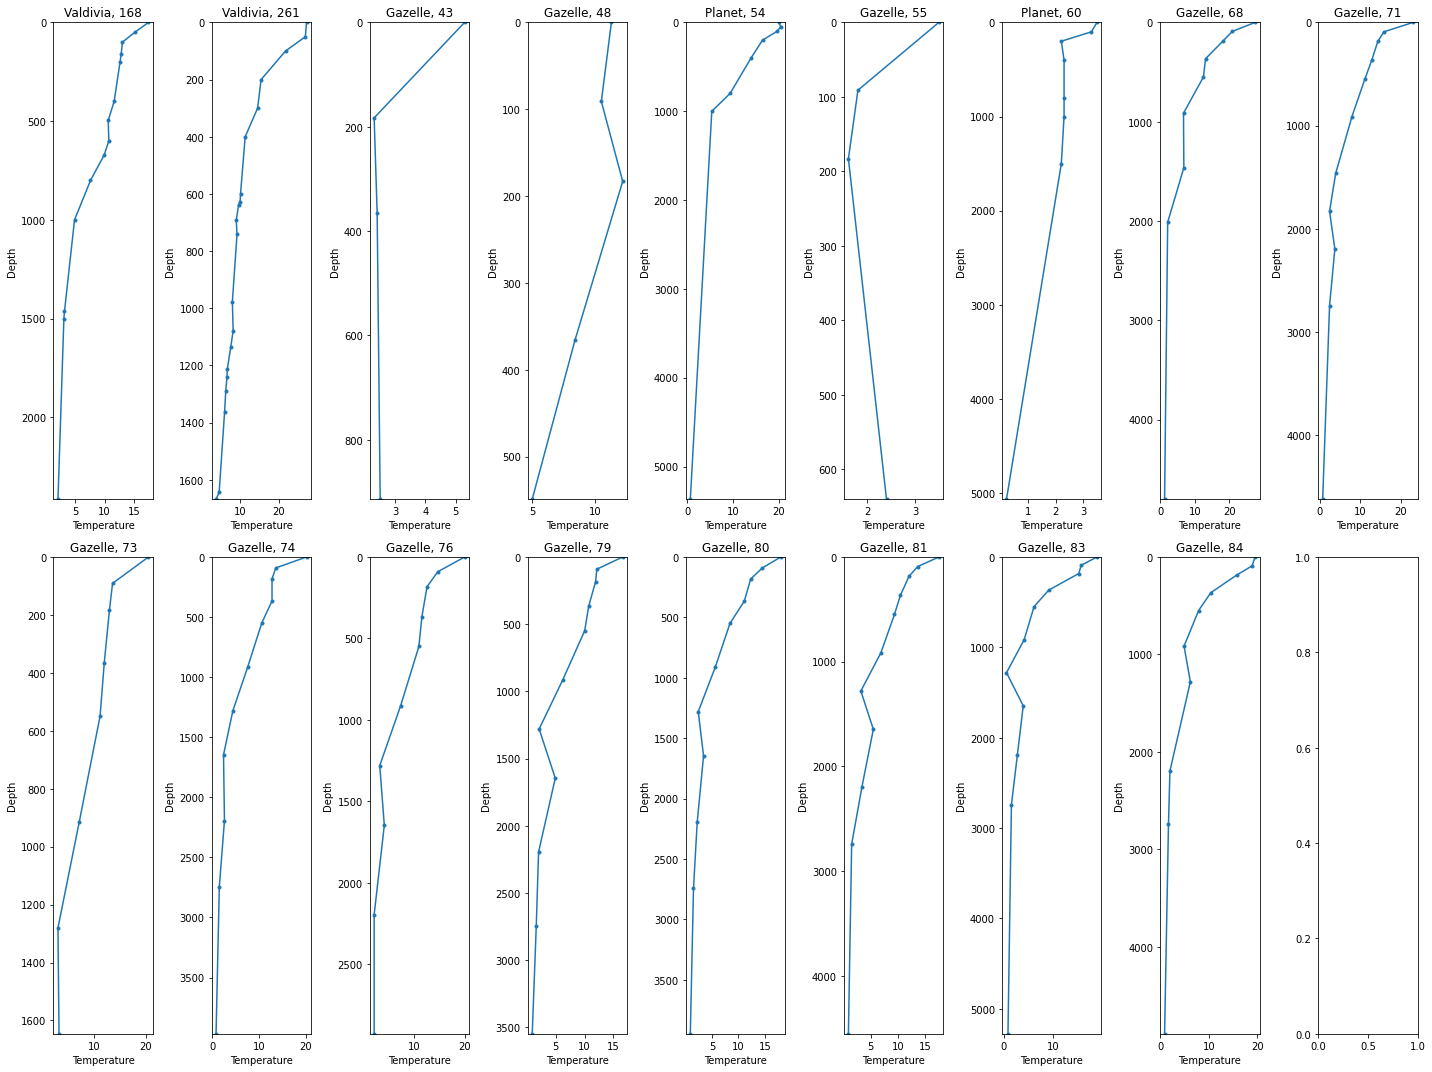

In [ ]:
ac = ALL_CRUISES.to_xarray()
ac = ac.where(ac.temp_inversion_hist, drop=True)

numinv = np.unique(ac.Station.values).size
print(numinv)
fig, ax = plt.subplots(2,9, figsize=(20, 15))
counter = 0
for s in np.unique(ac.Station.values):
  #print(s)
  index = ac.where(ac.Station==s, drop=True).index.values[0]
  flag, temp, t_dz, depth, depth_dz = checkInversion_hist(index, ALL_CRUISES, uplim=500)
  ax.ravel()[counter].plot(temp, depth, marker='.')
  ax.ravel()[counter].set_title(f'{ac.sel(index=index).cruise.values}, {s}')
  ax.ravel()[counter].set_ylim(np.max(depth), 0)
  ax.ravel()[counter].set_xlabel('Temperature')
  ax.ravel()[counter].set_ylabel('Depth')

  counter += 1

plt.tight_layout()

In [ ]:
# Stations to be removed
########################
# Remove because of inversions while using Min-Max thermometers
# (NOTE COULD ALSO TRY REMOVING PARTICULAR DEPTHS)
# Gazelle stations 48 (but shallow), 55, 71(?, d=2195), 76 (d=1646), 79 (d=1646), 80(?, d=1646), 81(?, d=1646), 83 (d=1646), 84 (d=1280)

# Remove because of inversions in WOA (assume Valdivia used reversing thermometers)
# Gazelle stations 45, 55, 56

In [ ]:
ac = ALL_CRUISES.to_xarray()
ac = ac.where(ac.temp_inversion_hist, drop=True)

ac = ac.where(ac.Station=='84', drop=True)
ac.Depth.values

array([   0.,   91.,  183.,  366.,  549.,  914., 1280., 2195., 2743.,
       4892.])

In [ ]:
ac = ALL_CRUISES.to_xarray()
ac = ac.where(ac.temp_inversion, drop=True)

#fig, ax = plt.subplots(6,6)
#for i in ac.index.values:
  #
#  ac[i].Station

print(ac.Station.values)
print(ac.cruise.values)
print(ac.index.values)

#Should actually remove station 45, 55, 56, 
print(ac.where(ac.Station=='45', drop=True).index.values)

AttributeError: ignored